# EDA for Used Car Data

<div class="alert alert-block alert-info">
    
### Source Dataset :  

9337 used car listings scraped from a car website and augmented with additional data.
Please refer to the file UsedCarDataPreparation for details on the data synthesis

### EDA Objectives: 

1. Describe basic statistical data of the dataset
2. Explore data quality - Variances, Outliers, Distributions, Skewness
3. Perform label encoding and explore relationships
4. Execute initial basic model and explore results.

</div>



In [1]:
# Libraries for data processing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.set_option('display.max_colwidth',0)
pd.set_option('display.float_format',lambda x: '%.2f' %x)
pd.set_option('display.max_rows',300)
pd.set_option('display.max_columns',0)
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import missingno as msno
import itertools
import math
from datetime import datetime


In [52]:
# Libraries for modeling and encoding
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVR
from xgboost import XGBRegressor,plot_importance
from sklearn.metrics import mean_absolute_error,roc_curve, auc,mean_squared_error,make_scorer,classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from scipy.stats import uniform, truncnorm, randint
from mlxtend.regressor import StackingCVRegressor,StackingRegressor
from sklearn.linear_model import Lasso, Ridge

In [3]:
# Plot functions

def boxplots(df,columns):
    
    df1 = df[columns].copy()

    for col in df1.select_dtypes(exclude=['float64','int64']):
        df1[col] = df1[col].astype('category')
        df1[col] = df1[col].cat.codes        
    
    N = len(columns)
    cols = 3
    rows = int(math.ceil(N / cols))
    gs = gridspec.GridSpec(rows, cols,wspace=0.3,hspace=0.9)
    fig = plt.figure(figsize=(22, 10))
    for n in range(N):
        ax = fig.add_subplot(gs[n])
        sns.boxplot( y=df1[columns[n]],palette="Set3",orient = 'h',ax = ax )
        ax.grid(True)
        ax.set_title('Distribution of '+ columns[n], fontsize=15) 


def scatterplots(df,x_cols,y_col):

    N = len(x_cols)
    cols = 3
    rows = int(math.ceil(N / cols))
    gs = gridspec.GridSpec(rows, cols,wspace=0.2,hspace=0.8)
    fig = plt.figure(figsize=(21, 6))
    for n in range(N):
        ax = fig.add_subplot(gs[n])
        sns.scatterplot(x = x_cols[n], y = y_col, data=df, ax = ax)
        ax.set_title(x_cols[n] + ' vs ' + y_col, fontsize=15) 


def histograms(df, columns,xlen):        
    N = len(columns)
    cols = 3
    rows = int(math.ceil(N / cols))
    gs = gridspec.GridSpec(rows, cols,wspace=0.3,hspace=1.0)
    fig = plt.figure(figsize=(xlen, 6))
    for n in range(N):
        ax = fig.add_subplot(gs[n])
        df[columns[n]].value_counts().plot(kind = 'bar',ax = ax)
        ax.set_title(columns[n], fontsize=15)      

def getmissing(df):
    s = df.isnull().sum() 
    s = s[s>0]
    if len(s) == 0:
        print("There are no columns with nulls")
        return
    print("Columns with missing data: \n")
    print(s)
    s.plot(kind = 'barh')
    
def info(df):  
    print(str(len(df.columns)) + ' columns') 
    df1 = pd.concat([df.nunique(),df.isnull().sum(),df.dtypes], axis = 1)
    df1.columns = ['unique values','nullvalues','data type']
    print(df1['data type'].value_counts())
    return df1

def sample(df):
    return df.sample(5, random_state = 10)


In [4]:
# boxplots(df = df, columns = ['year','AvgMPG','accidenthist','owner'])
# scatterplots(df = df, x_cols = ['PercentSales', 'AvgDaysToTurn','ReviewScore', 'AvgMPG'], y_col = 'price', make = 'HONDA')
# histograms(df = df , columns = ['year','pricecategory', 'accidenthist', 'owner','make','usage'])

# <span style="color:Blue"> Step 1: Read dataset, describe basic statistical data of the dataset, missing values </span>

In [5]:
# read the cars data from csv
df = pd.read_csv('cardata_final.csv',encoding = "ISO-8859-1",index_col=False)

In [6]:
# Shuffle the dataset with df.sample(frac=1)
# Split the data set into a train+test set (80%) and a holdout set (20%)
# holdout set will be used for final model testing
df, df_hold = np.split(df.sample(frac=1), [int(.8*len(df))])

In [ ]:
df

In [7]:
len(df)

7469

In [8]:
len(df_hold)

1868

In [9]:
sample(df)

,vin,year,make,model,trim,pricecategory,price,mileage,city,state,colorexterior,colorinterior,accidenthist,owner,usage,discount,bodytype,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,LuxurySportsOrHybrid
4973,5YFEPRAE4LP012856,2020,TOYOTA,COROLLA,LE CVT,GREAT PRICE,18888,16124,WHITTIER,CA,WHITE,BLACK,0,1,PERSONAL,Y,SEDAN,5.00,49,12.19,43.23,7.90,32.00,N
7687,5TDZA23C65S372016,2005,TOYOTA,SIENNA,LE 7-PASSENGER FWD,NOT LISTED,4100,144354,PRINCETON,NJ,BLUE,GRAY,1,1,PERSONAL,N,VAN/MINIVAN,5.00,43,12.19,43.23,8.10,23.00,N
7612,1GCRYDED9LZ101993,2020,CHEVROLET,SILVERADO 1500,LT DOUBLE CAB STANDARD BED 4WD,GREAT PRICE,33997,8746,FOND DU LAC,WI,WHITE,BLACK,0,1,PERSONAL,Y,PICKUP,9.00,24,11.69,78.23,8.40,21.50,N
7633,1GNSKHKC2KR204121,2019,CHEVROLET,SUBURBAN,LT 4WD,GREAT PRICE,40645,37164,BROOKSVILLE,FL,WHITE,BLACK,0,1,PERSONAL,Y,SUV,9.00,27,11.69,78.23,7.60,18.50,N
8419,5N1AZ2MG5HN181927,2017,NISSAN,MURANO,2017.5 PLATINUM FWD,EXCELLENT PRICE,23805,29568,CARROLLTON,GA,WHITE,BEIGE,0,1,PERSONAL,Y,SUV,16.00,10,6.29,76.23,7.80,24.00,N


In [10]:
info(df)

24 columns
object     13
int64      6 
float64    5 
Name: data type, dtype: int64


,unique values,nullvalues,data type
vin,7469,0,object
year,24,0,int64
make,44,0,object
model,377,0,object
trim,1235,0,object
pricecategory,4,0,object
price,3646,0,int64
mileage,7101,0,int64
city,1334,0,object
state,50,0,object


In [11]:
df.describe()

,year,price,mileage,accidenthist,owner,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG
count,7469.00,7469.00,7469.00,7469.00,7469.00,7407.00,7469.00,7412.00,7397.00,6928.00,6923.00
mean,2016.36,16653.37,54433.64,0.19,1.43,14.46,26.06,6.82,70.63,7.86,28.10
std,3.97,8943.41,46398.30,0.47,0.89,6.82,14.39,4.36,15.80,0.58,6.75
min,1997.00,1500.00,8.00,0.00,0.00,2.00,1.00,0.00,23.23,5.30,15.00
25%,2015.00,10583.00,25930.00,0.00,1.00,9.00,14.00,2.22,57.92,7.40,23.50
50%,2018.00,15677.00,35768.00,0.00,1.00,14.00,27.00,6.29,74.00,7.90,28.50
75%,2019.00,19995.00,73270.00,0.00,2.00,18.00,38.00,11.69,78.23,8.30,32.50
max,2020.00,69900.00,395720.00,5.00,10.00,32.00,52.00,13.83,123.69,9.30,131.00


<div class="alert alert-block alert-success">
    
### Results and Observations for Step 1 - Basic Stats on data :

1. 24 columns are present in the data set consisting of 11 numerical and 13 non-numerical variables
    
2. As this data set is generated as part of data acquisition phase of this project , _most of the data is already standardized during the data synthesis process_.   
    
3. Nulls observed in a group of fields which are related to market reviews and sales. This is due to unavailability of data for those makes - most of them are European makes or super luxury brands.
    
4. Proposed target variables - "price" and "pricecategory" are all non-null. 
    
5. Most of the cars listed are either 1 or 3 years old. 25% to 75% of the cars are within 2015 to 2019.
    
6. 75% of the listings have prices within 20k. Most of the cars are in range 10-20k. Typical of used car values for cars older than 2 years.
    
7. Nissan, Ford, Toyota, Hyndai, Chevrolet and Honda are the most frequently occuring Makes in the listing.
    
  
</div>


## <span style="color:Blue"> Step 2: Explore data quality - Variances, Missing Values, Outliers, Distributions, Skewness </span>

### Missing data analysis


Columns with missing data: 

ReliabilityRank         62 
PercentSales            57 
AvgDaysToTurn           72 
ReviewScore             541
AvgMPG                  546
LuxurySportsOrHybrid    541
dtype: int64


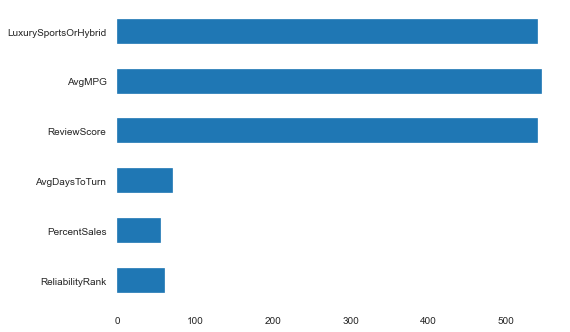

In [12]:
getmissing(df)

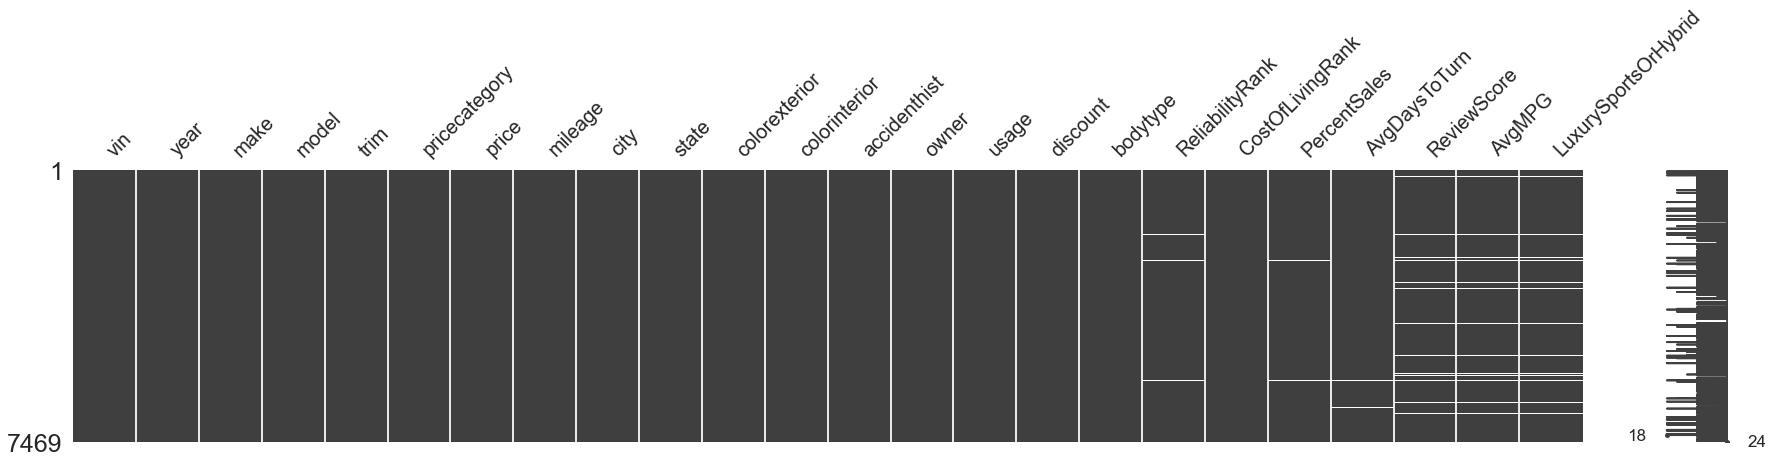

In [13]:
msno.matrix(df,figsize=(30,5), fontsize=20)

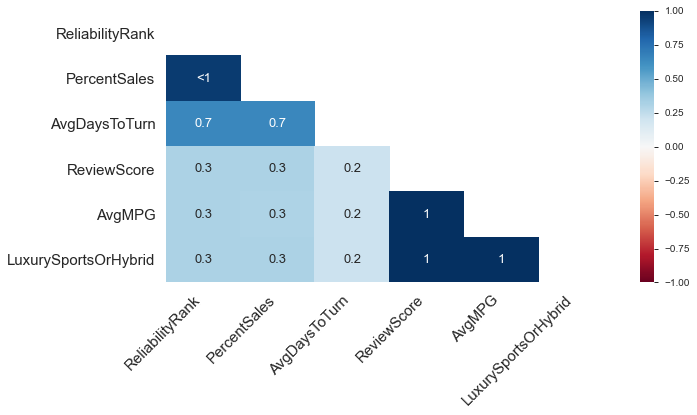

In [14]:
msno.heatmap(df,figsize=(10,5), fontsize=15)

<div class="alert alert-block alert-danger">
    
<br>   
   
#### **OBSERVATION : Missing Values**

    
- The NULL vlues in the columns are not clustered around any specific point, it is evenly distributed.
    
- Columns with Null value show correlations - this is because they are extracted from same or similar datasets from same population sample (reviews for a particular year range or specific makes)
   
<br>    
- (ReliabilityRank,PercentSales,AvgDaysToTurn)  are highly correlated for NULL values as they come from similar data set
<br>
- (ReviewScore, AvgMPG,LuxurySportsOrHybrid)  are perfectly correlated for NULL values as they come from same data set.

<br>
    
_The samples with null values are either from Super Luxury brands or from models older than 2012 which were beyond the scope of the data capture process._
 
#### **ACTION : Imputation of missing values  


| Columns with Missing Values |  Impute Strategy 
| --- |  --- 
| AvgMPG,ReliabilityRank,PercentSales,AvgDaysToTurn,ReviewScore | -1
| LuxurySportsOrHybrid  |  'U'

    
- Add a new columns to indicate absence of data for the above fields as described below:

    
| New Indicator Column | Value determination
| --- |  --- 
| ReviewDataAvailable | 'N' if **any one** of the following columns is NULL, else 'Y'
    
    

   
</div>

### Skew and Outlier analysis


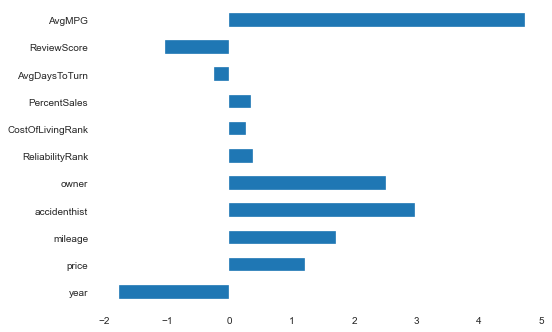

In [15]:
# check Skewness of columns
df.skew().plot(kind = 'barh')

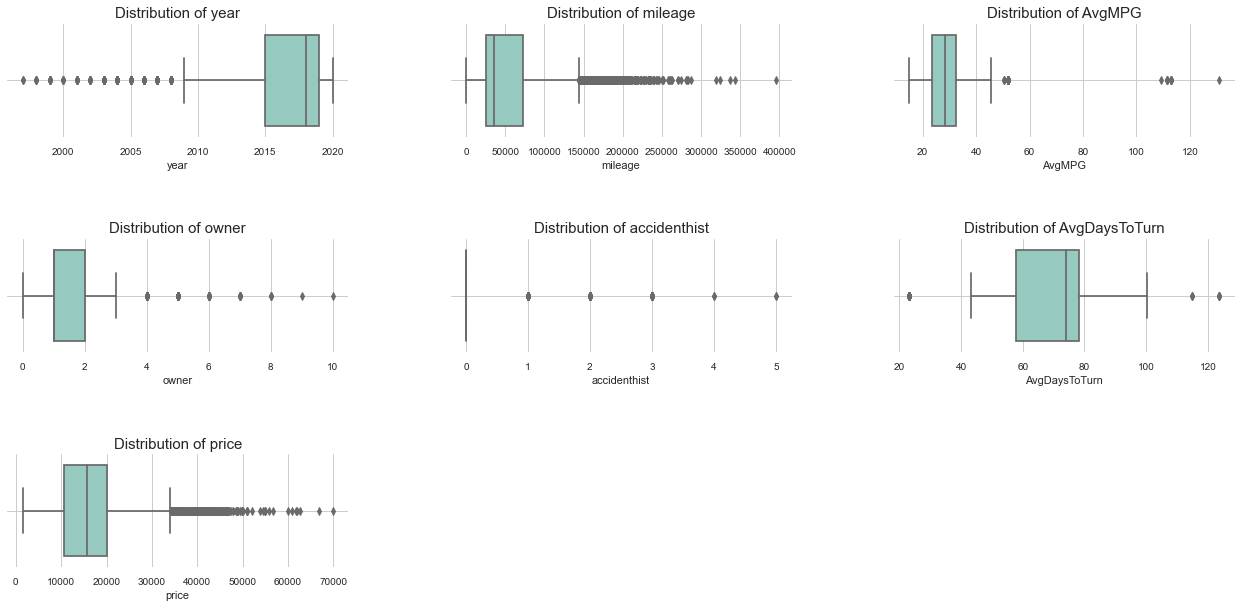

In [16]:
boxplots(df = df, columns = ['year','mileage','AvgMPG','owner','accidenthist','AvgDaysToTurn','price'])

<div class="alert alert-block alert-danger">

#### **OBSERVATION : Skewness**

- Most of the columns have the common/usual values seen in used car data. So these do not really have outliers. 
    
    accidenthist,owner show skewness in the typical values of used cars  <br>
    year shows skewness for 2015 - 2019 which is typical age of listed used cars <br>
    reviewscore has lot of values 6.5 to 8 <br>
    

#### **OBSERVATION : Outliers**

- **Outliers seen for year < 2008** : It is common for used cars listings to have cars older than 10-15 years. 
    
- **Outliers seen for mileage > 150000** : It is common for used cars to have mileage > 150000, but here mileage values > 250000 are observed

- **Outliers seen for AvgMPG > 45** :  Electric/Hybrid/small may have AvgMPG > 45
    
- **Outliers seen for owner > 4** :  It is common for used cars listings to have more than 1 owners
    
- **Outliers seen for accidenthist > 0** :  It is uncommon for used car listings to have more than 2 accidents, No accident is most common

- **Outliers seen for price > 35000** :  Prices beyond 50k is very rare unless for used cars
    
    
#### **ACTION : Creation of Dervied features**
    
Deriving new categorical features will help in reducing the effect of outliers
    
    
</div>

### Missing data handling - imputations, creation of additional attributes 

In [17]:
# Function to clip outliers outside mean +- 2SD
def clipoutliers_2SD(df,columns):
    df2 = df.copy()    
    for col in columns:          
        ulim = df2[col].mean() + 2*df2[col].std()
        llim = df2[col].mean() - 2*df2[col].std()
        df2[col] = df2[col].clip(llim,ulim)
    return df2

In [18]:
# Reduce the number of possible values of a feature
# Either by creating new features or converting them into categorical

# Imputation for columns: 'AvgMPG','ReliabilityRank','PercentSales','AvgDaysToTurn','ReviewScore' set to column median
for col in ['AvgMPG','ReliabilityRank','PercentSales','AvgDaysToTurn','ReviewScore']:
    df[col] = df[col].fillna(df[col].median()) 


# Imputation for 'LuxurySportsOrHybrid', set as 'U' - unknown
df['LuxurySportsOrHybrid'].fillna('U',inplace = True)

   
# extract drivetrain from the trim
# missing data is assigned FWD. 
# FWD and 2WD is mapped to FWD
# AWD, RWD, 4WD are mapped to AWD
df['drivetrain'] = df['trim'].apply(lambda x:[d for d in ['AWD','RWD','FWD','4WD','2WD'] if d in x])
df['drivetrain'] = df['drivetrain'].apply(lambda x:x[0] if len(x) > 0 else 'FWD')
df['drivetrain'] = df['drivetrain'].apply(lambda x:'FWD' if x in ['FWD','2WD'] else 'AWD')    
    
# convert year to age
df['age'] = 2020 - df['year'] 

# convert mileage value to thousands and rename to odo
df['odo'] = df['mileage']/1000 

# Convert to categorical 
# convert owners and accidenthist to 3 groups
df['owner'] = pd.cut(x=df['owner'], bins=[-1,0,1,20], labels=[0,1,2])
df['accidenthist'] = pd.cut(x=df['accidenthist'], bins=[-20,0,20], labels=['N', 'Y'])


# clip outliers to mean +/- 2 SD
df = clipoutliers_2SD(df = df,columns = ['age','odo','AvgMPG','AvgDaysToTurn','price'])

# drop the root columns that were used to derive the categorical columns
df = df.drop(columns = ['year','trim','mileage']) 


In [19]:
sample(df)

,vin,make,model,pricecategory,price,city,state,colorexterior,colorinterior,accidenthist,owner,usage,discount,bodytype,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,LuxurySportsOrHybrid,drivetrain,age,odo
4973,5YFEPRAE4LP012856,TOYOTA,COROLLA,GREAT PRICE,18888.00,WHITTIER,CA,WHITE,BLACK,N,1,PERSONAL,Y,SEDAN,5.00,49,12.19,43.23,7.90,32.00,N,FWD,0.00,16.12
7687,5TDZA23C65S372016,TOYOTA,SIENNA,NOT LISTED,4100.00,PRINCETON,NJ,BLUE,GRAY,Y,1,PERSONAL,N,VAN/MINIVAN,5.00,43,12.19,43.23,8.10,23.00,N,FWD,11.57,144.35
7612,1GCRYDED9LZ101993,CHEVROLET,SILVERADO 1500,GREAT PRICE,33997.00,FOND DU LAC,WI,WHITE,BLACK,N,1,PERSONAL,Y,PICKUP,9.00,24,11.69,78.23,8.40,21.50,N,AWD,0.00,8.75
7633,1GNSKHKC2KR204121,CHEVROLET,SUBURBAN,GREAT PRICE,34540.19,BROOKSVILLE,FL,WHITE,BLACK,N,1,PERSONAL,Y,SUV,9.00,27,11.69,78.23,7.60,18.50,N,AWD,1.00,37.16
8419,5N1AZ2MG5HN181927,NISSAN,MURANO,EXCELLENT PRICE,23805.00,CARROLLTON,GA,WHITE,BEIGE,N,1,PERSONAL,Y,SUV,16.00,10,6.29,76.23,7.80,24.00,N,FWD,3.00,29.57


#### POST-IMPUTE AND STANDARDIZATION CHECKS

In [20]:
# Check null value distribution after impute
getmissing(df)

There are no columns with nulls


In [21]:
info(df)

24 columns
object      13
float64     8 
category    1 
int64       1 
category    1 
Name: data type, dtype: int64


,unique values,nullvalues,data type
vin,7469,0,object
make,44,0,object
model,377,0,object
pricecategory,4,0,object
price,3351,0,float64
city,1334,0,object
state,50,0,object
colorexterior,17,0,object
colorinterior,10,0,object
accidenthist,2,0,category


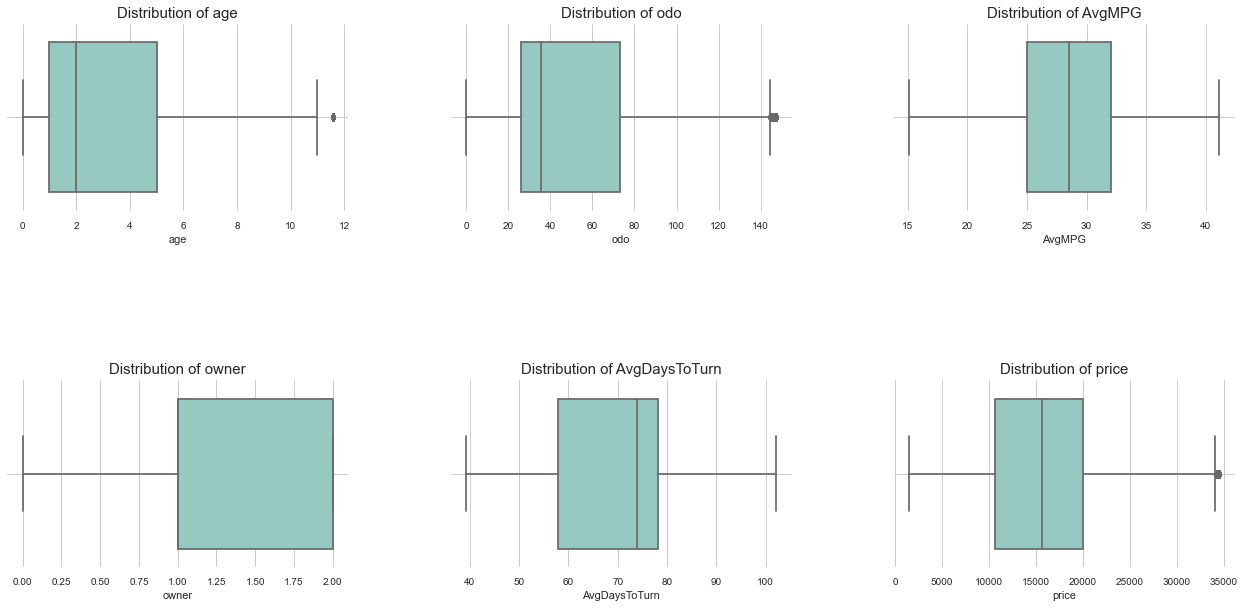

In [22]:
boxplots(df = df, columns = ['age','odo','AvgMPG','owner','AvgDaysToTurn','price'])

<div class="alert alert-block alert-success">
    
### Results and Observations for Step 2 - Handling missing data and outliers:

1. All missing data were imputed based on the logic described above.
    
2. Outliers have been detected and removed to mean +/- 2SD. 
    
3. Derived columns have been created from  the columns having outliers and original columns have been removed.
    
</div>


## <span style="color:Blue"> Step 3: Explore relationships </span>

#### Get a subset of the most listed make models

In [23]:
df1 = df.copy()
df1['makemodel'] = df1['make'].astype(str) + ' ' +  df1['model'].astype(str)
df1 = df1[['makemodel','pricecategory', 'price','state','CostOfLivingRank','colorexterior', 'colorinterior', 'accidenthist', 'owner', 'usage','discount','age','odo']]
df1.loc[:,'odo'] = df1.loc[:,'odo'].apply(lambda x:round(x,0))
df1.loc[:,'price'] = df1.loc[:,'price'].apply(lambda x:round(x/100,2))
df1.groupby(['makemodel']).size().reset_index(name='count').sort_values(['count'], ascending = False).head(10)

,makemodel,count
166,HYUNDAI ELANTRA,394
294,NISSAN ROGUE,377
297,NISSAN SENTRA,351
108,DODGE GRAND CARAVAN,344
133,FORD FUSION,329
341,TOYOTA CAMRY,267
280,NISSAN ALTIMA,240
343,TOYOTA COROLLA,234
155,HONDA CIVIC,212
154,HONDA ACCORD,198


#### Filter data for the three most common make model

In [24]:
df1 = df1[(df1['makemodel'].isin(['HYUNDAI ELANTRA','NISSAN ROGUE','NISSAN SENTRA']))]

#### Plot Odometer vs Price : age/owner/accidenthist constant
_Negative correlation observed between odometer and price_

_price cateogories dont show any specific relationships_

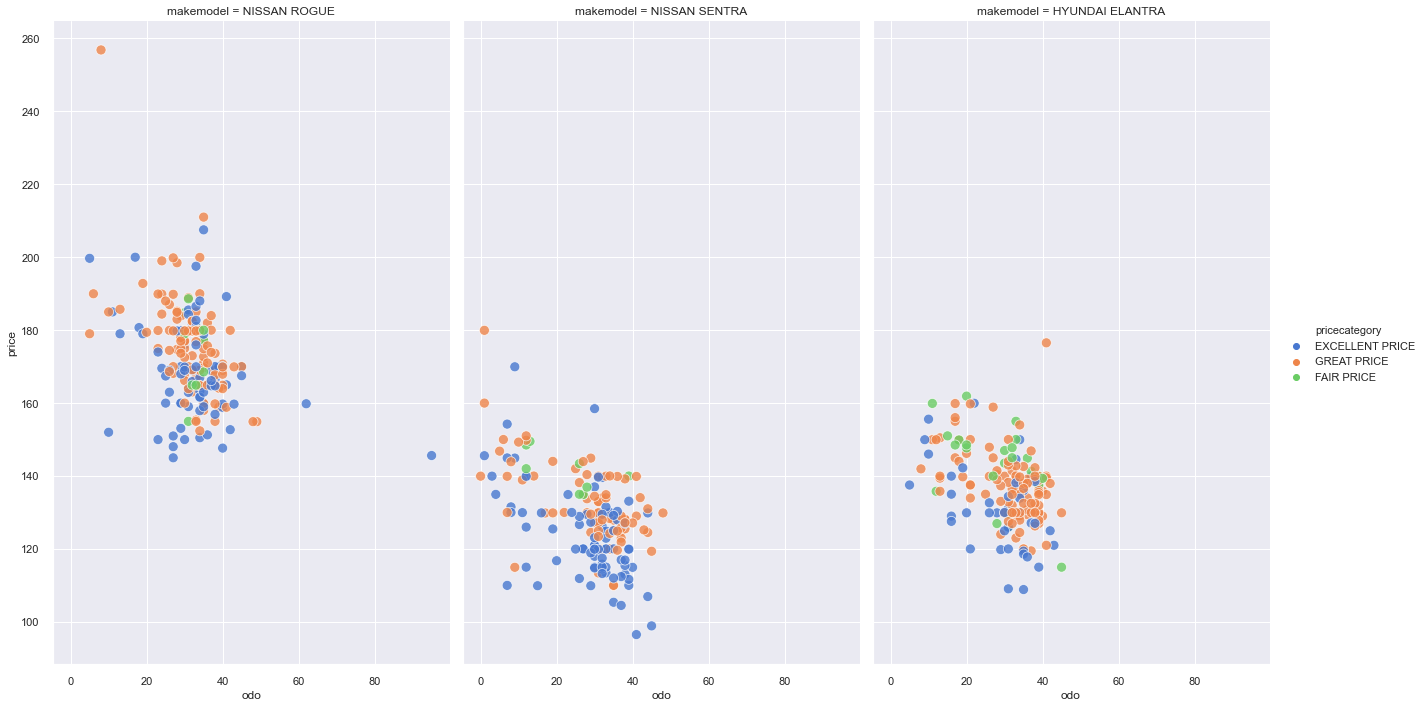

In [25]:
sns.set(style="darkgrid")
sns.relplot(x = 'odo', y = 'price', 
                hue='pricecategory', 
                alpha=.8, 
                palette="muted", 
                height=10,
                aspect=0.6,
                col = 'makemodel',
                s=100,
                data=df1[(df1['owner'] == 1) & (df1['age'] == 1) & (df1['accidenthist'] == 'N')]) 


#### Plot CostOfLivingRank  vs Price : odometer/owner/age constant
_No correlation observed between CostOfLivingRank and price_

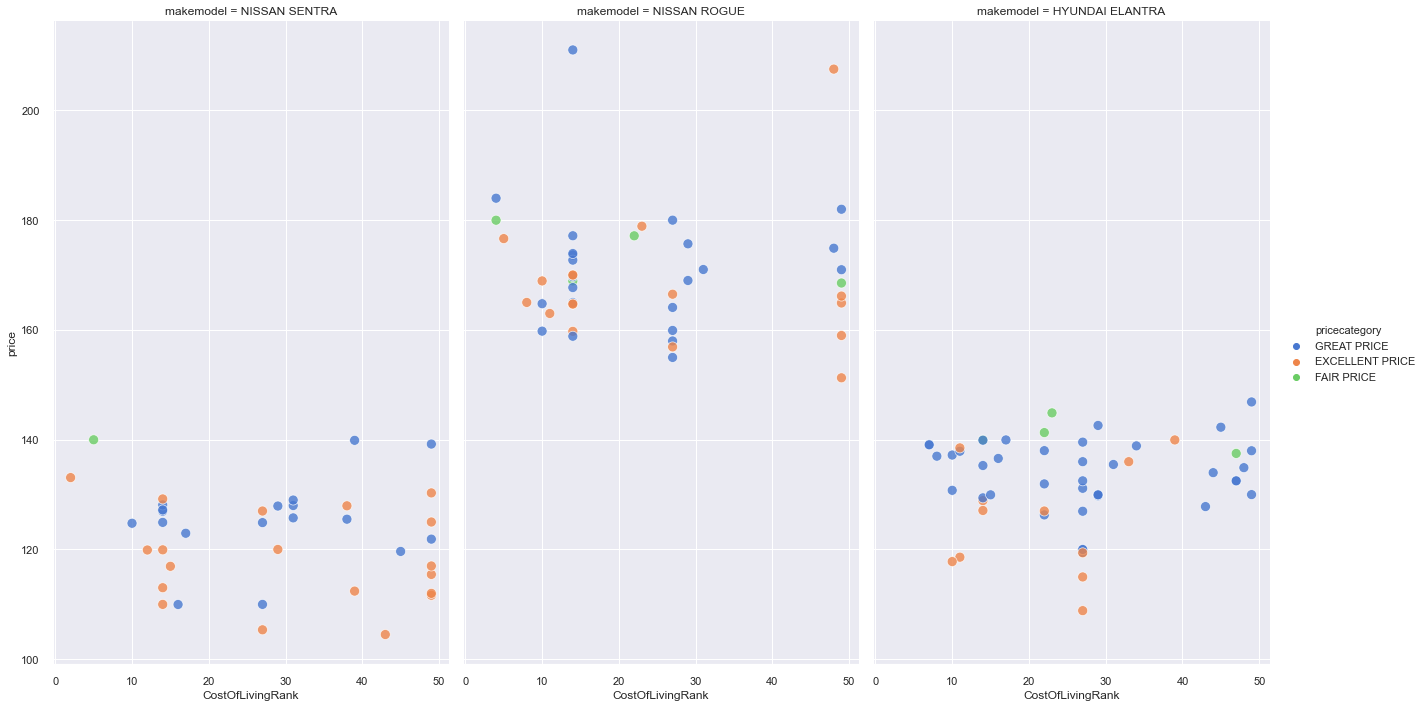

In [26]:
sns.set(style="darkgrid")
sns.relplot(x = 'CostOfLivingRank', y = 'price', 
                hue='pricecategory', 
                alpha=.8, 
                palette="muted", 
                height=10,
                aspect=0.6,
                col = 'makemodel',
                s=100,
                data=df1[(df1['odo'].between(35,39)) & (df1['owner'] == 1) & (df1['age'] == 1) & (df1['accidenthist'] == 'N')]) 


#### Plot Age  vs Price : odometer/owner constant
_Negative correlation observed between age and price_

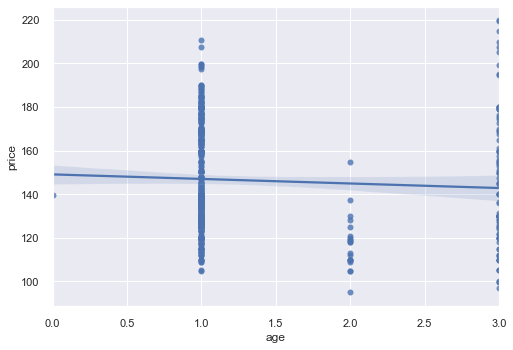

In [27]:
sns.set(style="darkgrid")
sns.regplot(x = 'age', y = 'price', 
               
                data=df1[(df1['odo'].between(20,39)) & (df1['owner'] == 1) & (df1['accidenthist'] == 'N')]) 


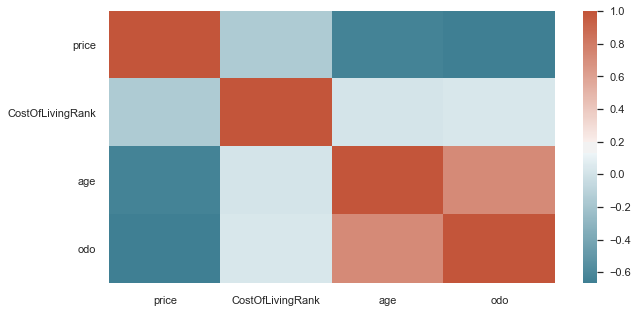

In [28]:
# plot the correlation heatmap for all columns
corr = df1.corr()
plt.figure(figsize = (10,5))
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=False, cmap=sns.diverging_palette(220, 20, as_cmap=True))

## <span style="color:Blue"> Step 4: Encode Data </span>

In [29]:
# drop unwanted columns 
df2 = df.copy()
df2 = df2.drop(columns = ['vin', 'city', 'state','make','model','discount'])
# create onehot for the columns with low cardinality
dum_cols = ['owner', 'usage','LuxurySportsOrHybrid','drivetrain','accidenthist']
df2 = pd.get_dummies(df2, columns = dum_cols)

In [30]:
info(df2)

25 columns
uint8      12
float64    8 
object     4 
int64      1 
Name: data type, dtype: int64


,unique values,nullvalues,data type
pricecategory,4,0,object
price,3351,0,float64
colorexterior,17,0,object
colorinterior,10,0,object
bodytype,11,0,object
ReliabilityRank,31,0,float64
CostOfLivingRank,50,0,int64
PercentSales,33,0,float64
AvgDaysToTurn,29,0,float64
ReviewScore,31,0,float64


In [31]:
# create a custom Encoder class to handle new unseen values as UNKNOWN 
# this is an extension of the sklearn Label Encoder class
class MyLabelEncoder():
    
    # initialize encoder with base constructor of LabelEncoder
    def __init__(self):
        self.encoder = LabelEncoder()

    def fit(self, values):
        # add a category "UNKNOWN"
        # this will be used as the category when an "unseen" value shows up in the data set
        self.encoder = self.encoder.fit(list(values) + ['UNKNOWN'])
        self.classes_ = self.encoder.classes_

    def transform(self,values):

        values = list(values)
        # for each item in new values
        for item in np.unique(values):
            # if the item is not in the encoder classes (new unseen value   ) mark it as 'UNKNOWN'
            if item not in self.classes_:
                values = ['UNKNOWN' if x == item else x for x in values]

        return self.encoder.transform(values)

# Function to build encoder list for columns which are non-numeric
# Generate a dictionary of encoders to be used for test set
def generate_label_encoders(df):

    encdict = {}

    for col in df.select_dtypes(include = ['object']).columns:
        enc = MyLabelEncoder()
        enc.fit(df[col])
        encdict.update({col : enc})

    return encdict 


# Encode the data using the passed in encoders

def encode_data(df,encoders):

    df1 = df.copy()

    for col in df1.select_dtypes(include = ['object']).columns:
        df1[col]  = encoders[col].transform(df1[col])

    return df1

In [32]:
encoders = generate_label_encoders(df2)

In [33]:
df2 = encode_data(df2,encoders)

In [34]:
sample(df2)

,pricecategory,price,colorexterior,colorinterior,bodytype,ReliabilityRank,CostOfLivingRank,PercentSales,AvgDaysToTurn,ReviewScore,AvgMPG,age,odo,owner_0,owner_1,owner_2,usage_FLEET,usage_PERSONAL,LuxurySportsOrHybrid_N,LuxurySportsOrHybrid_U,LuxurySportsOrHybrid_Y,drivetrain_AWD,drivetrain_FWD,accidenthist_N,accidenthist_Y
4973,2,18888.00,15,1,4,5.00,49,12.19,43.23,7.90,32.00,0.00,16.12,0,1,0,0,1,1,0,0,0,1,1,0
7687,3,4100.00,2,4,10,5.00,43,12.19,43.23,8.10,23.00,11.57,144.35,0,1,0,0,1,1,0,0,0,1,0,1
7612,2,33997.00,15,1,3,9.00,24,11.69,78.23,8.40,21.50,0.00,8.75,0,1,0,0,1,1,0,0,1,0,1,0
7633,2,34540.19,15,1,6,9.00,27,11.69,78.23,7.60,18.50,1.00,37.16,0,1,0,0,1,1,0,0,1,0,1,0
8419,0,23805.00,15,0,6,16.00,10,6.29,76.23,7.80,24.00,3.00,29.57,0,1,0,0,1,1,0,0,0,1,1,0


In [35]:
info(df2)

25 columns
uint8      12
float64    8 
int64      5 
Name: data type, dtype: int64


,unique values,nullvalues,data type
pricecategory,4,0,int64
price,3351,0,float64
colorexterior,17,0,int64
colorinterior,10,0,int64
bodytype,11,0,int64
ReliabilityRank,31,0,float64
CostOfLivingRank,50,0,int64
PercentSales,33,0,float64
AvgDaysToTurn,29,0,float64
ReviewScore,31,0,float64


In [36]:
# Ensure No Nulls
assert df2.isnull().sum().sum() == 0

In [37]:
# Ensure No Non-Numeric
assert len(df2.select_dtypes(exclude = ['int64','float64','uint8']).columns) == 0 

<div class="alert alert-block alert-success">

### RESULT:  Data Encoding -  ALL NUMERIC , NO NULLS
    
- all categorical columns have been label encoded to numeric
- no non-numeric columns are present in the data set
- no null values are present in the data set
    
</div>

## <span style="color:Blue"> Step 5: Prepare feature vectors and execute Train-Test Split in 80/20 ratio </span>

In [38]:
# Get dependent and independent variables in arrays

# X is all columns except price
X = df2.loc[:,~df2.columns.isin(['price','pricecategory']) ]
# X labels would be used to identify feature importances
X_labels = df2.columns[~df2.columns.isin(['price','pricecategory'])]
y = df2['price']

# Train and Test for target variable "price"
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=0)


In [48]:
y_train

2772   21990.00
3001   9000.00 
5871   18198.00
3417   19087.00
3484   24998.00
         ...   
5593   16190.00
1269   13494.00
6121   16000.00
8294   6997.00 
6746   24900.00
Name: price, Length: 5975, dtype: float64

In [39]:
print(f'Sizes of sets : X_train = {len(X_train)}  y_train = {len(y_train)}  X_test = {len(X_test)}   y_test = {len(y_test)} ')

Sizes of sets : X_train = 5975  y_train = 5975  X_test = 1494   y_test = 1494 


## <span style="color:Blue"> Step 6: Feature selection/elemination from Ensemble models </span>
### <span style="color:Red"> Explore the feature importances indicated by the Random Forest Regressor and XG Boost Regressor  </span>



In [40]:
'''
Hyperparamter reference for Random Forest:

n_estimators : number of decision trees in the forest
max_features: number of features to select (auto/sqrt/log)
max_depth : The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
min_samples_split : The minimum number of samples required to split an internal node
min_samples_leaf : The minimum number of samples required to be at a leaf node
max_samples : If bootstrap is True, the number of samples to draw from X to train each base estimator.
'''   
# Create a Random Forest Regressor with default parameters
rf_price = RandomForestRegressor(random_state=1, 
                                 n_estimators = 2000, 
                                 max_depth = 15,
                                 max_features = 'auto',
                                 min_samples_leaf = 2,
                                 min_samples_split = 5)

rf_price.fit(X_train, y_train)

pred_price = rf_price.predict(X_test)

print("\nRESULTS FOR RANDOM FOREST REGRESSOR")
print("\n===================================")
print("\nMean Absolute Error (Random Forest): {}".format(round(mean_absolute_error(y_test, pred_price))))
print("\nModel Score (Random Forest): {}".format(rf_price.score(X_test,y_test)))
print("\nModel Params (Random Forest): {}".format(rf_price.get_params()))

###########################################################################################

'''
Hyperparamter reference for XGBoost:

n_estimators : number of decision trees in the forest
max_features: number of features to select (auto/sqrt/log)
max_depth : The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples
min_samples_split : The minimum number of samples required to split an internal node
min_samples_leaf : The minimum number of samples required to be at a leaf node
max_samples : If bootstrap is True, the number of samples to draw from X to train each base estimator.
''' 
# Create an XGB Regressor
xg_price = XGBRegressor(objective ='reg:squarederror', 
                        colsample_bytree = 0.6, 
                        learning_rate = 0.1,
                        max_depth = 15, 
                        alpha = 6, 
                        n_estimators = 2000)

xg_price.fit(X_train, y_train)

xg_pred_price = xg_price.predict(X_test)

print("\nRESULTS FOR XG BOOST REGRESSOR")
print("\n===================================")
print("\nMean Absolute Error (XGBoost): {}".format(round(mean_absolute_error(y_test, xg_pred_price))))
print("\nModel Score (XGBoost): {}".format(xg_price.score(X_test,y_test)))
print("\nModel Params (XGBoost): {}".format(xg_price.get_params()))






RESULTS FOR RANDOM FOREST REGRESSOR


Mean Absolute Error (Random Forest): 1440.0

Model Score (Random Forest): 0.906096880711759

Model Params (Random Forest): {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 15, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 2000, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}

RESULTS FOR XG BOOST REGRESSOR


Mean Absolute Error (XGBoost): 1435.0

Model Score (XGBoost): 0.908407454730917

Model Params (XGBoost): {'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.6, 'gamma': 0, 'gpu_id': -1, 'importance_type': 'gain', 'interaction_constraints': '', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weig

In [41]:
# Feature importance for Random Forest - list of columns
rf_feat_imp = pd.DataFrame(rf_price.feature_importances_,
                           index = X_labels,
                           columns = ['Importance_Score_RF']
                           )
rf_feat_imp.sort_values('Importance_Score_RF', ascending = False)

,Importance_Score_RF
age,0.36
AvgMPG,0.29
odo,0.11
LuxurySportsOrHybrid_N,0.07
ReviewScore,0.05
PercentSales,0.03
AvgDaysToTurn,0.02
bodytype,0.02
CostOfLivingRank,0.01
drivetrain_AWD,0.01


In [42]:
# Feature importance for XG Boost - list of columns
scores = xg_price.get_booster().get_score()
xg_feat_imp = pd.DataFrame.from_dict(scores, orient ='index', columns = ['Importance_Score_XG'])
xg_feat_imp.sort_values('Importance_Score_XG', ascending = False)

,Importance_Score_XG
odo,102969
CostOfLivingRank,88294
colorexterior,56993
ReliabilityRank,42091
ReviewScore,40812
colorinterior,38244
AvgMPG,34867
age,33184
bodytype,30742
PercentSales,28687


<div class="alert alert-block alert-success">
    
## Results and Observations for Step 6  - Feature Importance

Both the models show around 91% score with MAE = 1440.

Top features combining both models are:
    
    age
    AvgMPG
    odo
    LuxurySportsOrHybrid_Y
    LuxurySportsOrHybrid_N
    ReviewScore
    bodytype
    PercentSales
    AvgDaysToTurn
    drivetrain_AWD
    drivetrain_FWD
    ReliabilityRank
    CostOfLivingRank
    colorexterior
    colorinterior
    usage_FLEET
    accidenthist_N
    owner_1


    

</div>


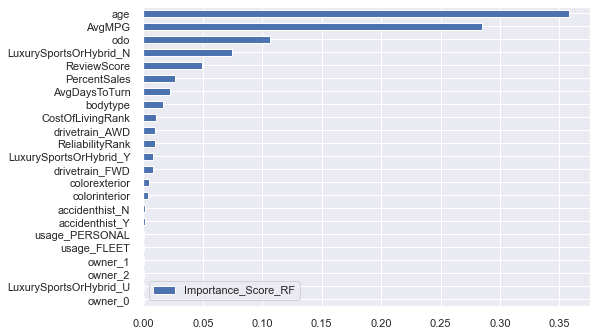

In [43]:
# Graph Representation of Importance Scores for Random Forest
rf_feat_imp.sort_values('Importance_Score_RF', ascending = True).plot(kind = 'barh')

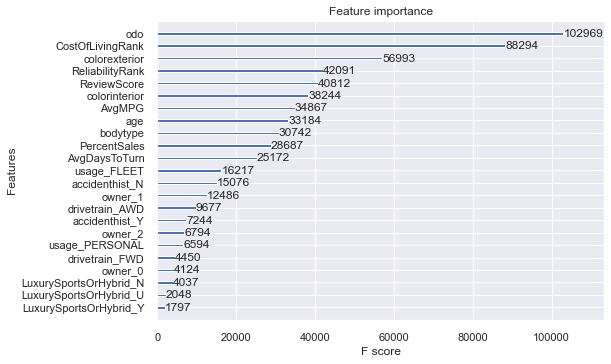

In [44]:
# Graph Representation of Importance Scores for XG Boost
plot_importance(xg_price)

## <span style="color:Blue"> Step 7: Explore multiple models with Stacking along with Grid Search  </span>

The following models are explored with Hyperparameter tuning.
A Stacking Regressor is used to achieve this along with Grid Search.
_2 ensemble tree based models and 2 linear models are selected for analysis_

- Random Forest Regressor
- XG Boost Regressor
- Linear Regressor
- SVM Regressor with RBF kernel

## Using a Stacking Regressor with Random Forest, XGBoost and SVR
### Refering to the optimal parameters obtained by individual model fitting

In [ ]:
from mlxtend.regressor import StackingRegressor

#Initializing base estimators
xg = XGBRegressor()
rf = RandomForestRegressor(random_state=1)
ls = Lasso()
svr = SVR(kernel='rbf')

#Initializing meta regressor
meta_svr = SVR(kernel='rbf')


regressors = [xg, rf, ls, svr]

#Stacking the various regressors initialized before
stack = StackingRegressor(regressors = regressors,
                          meta_regressor = meta_svr)

# Define grid search params
params = {  'randomforestregressor__max_depth': [5,10],
            'randomforestregressor__min_samples_leaf': [3,5],
            'randomforestregressor__n_estimators': [500,1000],
            'xgbregressor__gamma': [0.5, 1],
            'xgbregressor__max_depth':  [5,10],
            'xgbregressor__n_estimators': [500,1000],
            'lasso__alpha': [0.1, 1.0, 10.0],
            'svr__C':[0.001,0.1,10], 
            'svr__gamma':[0.1,0.01, 10.0],
            'meta_regressor__C': [0.1, 1.0, 10.0],
            'meta_regressor__gamma': [0.1, 1.0]
        }



# Check the parameters for Stacking Regressor. Need to use only those names.

grid = GridSearchCV(
                    estimator=stack, 
                    param_grid=params, 
                    cv=3,
                    verbose = 1,
                    refit=True
                    )

#Fitting the data
grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

#Predicting the Test set results
y_pred_stack = stack.predict(X_test)

#Evaluating
print("\n\nStackingCVRegressor SCORE : ", score(y_pred_stack, y_test))

Fitting 3 folds for each of 10368 candidates, totalling 31104 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [ ]:
started 12:12

In [53]:
# from mlxtend.regressor import StackingCVRegressor,StackingRegressor
# from sklearn.linear_model import Lasso

# #Initializing base estimators
# xg = XGBRegressor()
# rf = RandomForestRegressor(random_state=1)
# ls = Lasso()
# svr = SVR(kernel='rbf')

# #Initializing meta estimator
# meta_rf = RandomForestRegressor(random_state=1)
 
# #Stacking the various regressors initialized before
# stack = StackingCVRegressor(regressors = (xg,rf,ls,svr),
#                             meta_regressor = meta_rf, 
#                             use_features_in_secondary=True)

# # Check the parameters for Stacking Regressor. Need to use only those names.

# grid = GridSearchCV(
#                     estimator=stack, 
#                     param_grid={
#                         'randomforestregressor__max_depth': [5,10],
#                         'randomforestregressor__min_samples_leaf': [3,5],
#                         'randomforestregressor__n_estimators': [500,1000],
#                         'xgbregressor__gamma': [0.5, 1],
#                         'xgbregressor__max_depth':  [5,10],
#                         'xgbregressor__n_estimators': [500,1000],
#                         'lasso__alpha': [0.1, 1.0, 10.0],
#                         'svr__C':[0.001,0.1], 
#                         'svr__gamma':[0.1,0.01],
#                         'meta_regressor__n_estimators': [50,100]
#                         }, 
#                     cv=3,
#                     verbose = 1,
#                     refit=True
#                     )

# #Fitting the data
# grid.fit(X_train, y_train)

# print("Best: %f using %s" % (grid.best_score_, grid.best_params_))

# #Predicting the Test set results
# y_pred_stack = stack.predict(X_test)

# #Evaluating
# print("\n\nStackingCVRegressor SCORE : ", score(y_pred_stack, y_test))

In [ ]:
# ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22'] ['colorexterior', 'colorinterior', 'bodytype', 'ReliabilityRank', 'CostOfLivingRank', 'PercentSales', 'AvgDaysToTurn', 'ReviewScore', 'AvgMPG', 'age', 'odo', 'owner_0', 'owner_1', 'owner_2', 'usage_FLEET', 'usage_PERSONAL', 'LuxurySportsOrHybrid_N', 'LuxurySportsOrHybrid_U', 'LuxurySportsOrHybrid_Y', 'drivetrain_AWD', 'drivetrain_FWD', 'accidenthist_N', 'accidenthist_Y']
# expected f3, f15, f0, f18, f13, f21, f8, f4, f6, f17, f9, f5, f1, f19, f22, f10, f7, f16, f2, f20, f12, f11, f14 in input data
# training data did not have the following fields: LuxurySportsOrHybrid_N, odo, age, usage_FLEET, ReviewScore, AvgMPG, LuxurySportsOrHybrid_Y, PercentSales, colorexterior, AvgDaysToTurn, drivetrain_FWD, ReliabilityRank, bodytype, accidenthist_Y, accidenthist_N, LuxurySportsOrHybrid_U, owner_2, owner_1, usage_PERSONAL, CostOfLivingRank, colorinterior, owner_0, drivetrain_AWD
